## This notebook generates time series data in different ways: without regression, with regression.

In [2]:
#from timeseries_generator import LinearTrend, Generator, WhiteNoise, RandomFeatureFactor
#import pandas as pd
#%matplotlib inline


import pandas as pd
from pandas._libs.tslibs.timestamps import Timestamp
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prevents plots from being displayed twice (unique to Jupyter Notebooks)
%matplotlib inline


# Setting up parameters (this model doesn't support regression, see further below for regressive parameters)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='date'>)

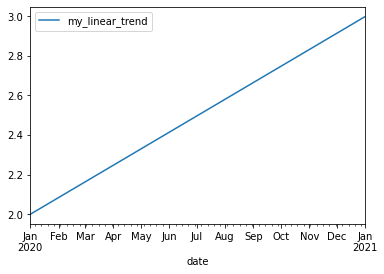

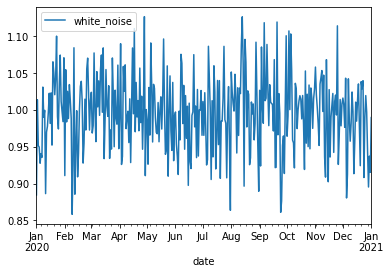

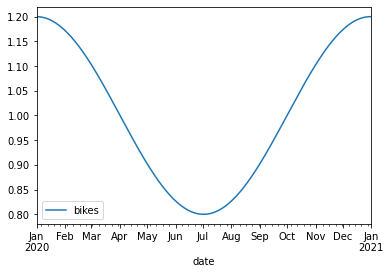

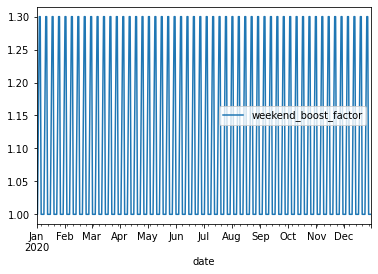

In [2]:
# The python package "timeseries_generator" implements day-increment granularity.
# The columns will have to be manually
start_date = Timestamp("01-01-2020")
end_date = Timestamp("01-01-2021")

features_dict = {
        "station": ["station_1", "station_2"],
        "product": ["bikes"]
}


linear_trend = LinearTrend(coef=1.0, offset=1., col_name="my_linear_trend")
white_noise = WhiteNoise(stdev_factor=0.05)

seasonality = SinusoidalFactor(
    feature="product",
    col_name="product_seasonal_trend_factor",
    feature_values={
        "bikes": {
            "wavelength": 365.,
            "amplitude": 0.2,
            "phase": 365/4,
            "mean": 1.
        }
    }
)


weekday_factor = WeekdayFactor(
    col_name="weekend_boost_factor",
    factor_values={4: 1.15, 5: 1.3, 6: 1.3}  # Here we assign a factor of 1.15 to Friday, and 1.3 to Sat/Sun 
)


# Plotting the parameters
linear_trend.plot(start_date=start_date, end_date=end_date)
white_noise.plot(start_date=start_date, end_date=end_date)
seasonality.plot(start_date=start_date, end_date=end_date)
weekday_factor.plot(start_date=start_date, end_date=end_date)  # Using a smaller timerange here to keep the plot viewable



# Creating generator

In [3]:
g: Generator = Generator(
    factors={
        linear_trend,
        seasonality,
        white_noise,
        #weekday_factor,
    },
    features=features_dict,
    date_range=pd.date_range(start=start_date, end=end_date),
    base_value=10
)
    
df = g.generate()

<AxesSubplot:xlabel='date'>

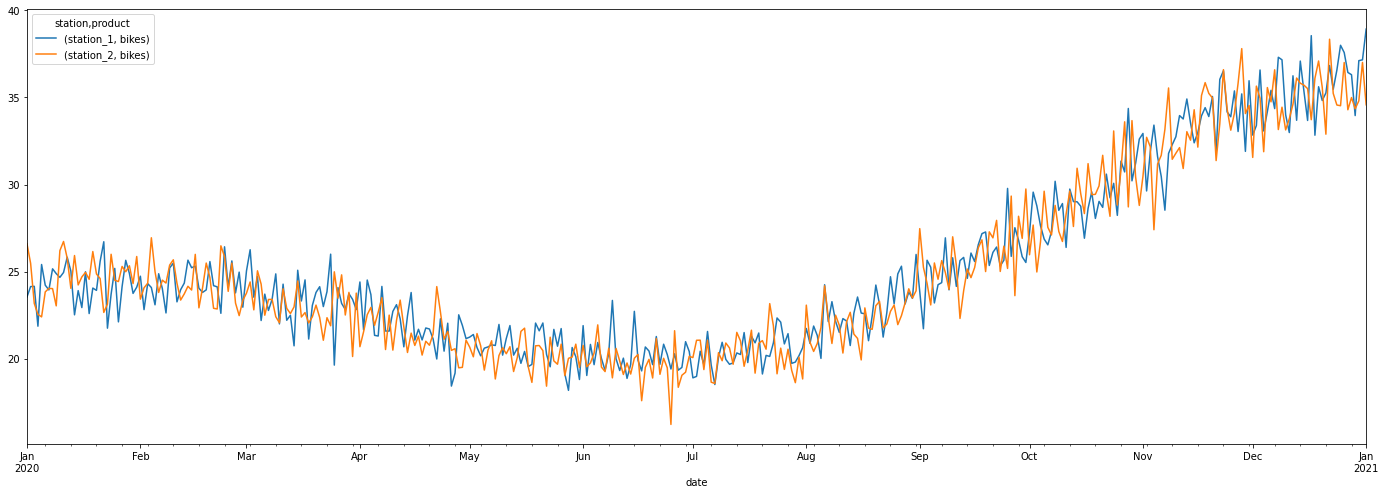

In [4]:

plot_df = df.set_index('date')
plot_df[['station', 'product', 'value']].pivot(columns=['station', 'product'], values='value').plot(figsize=(24,8))

In [5]:
df.head()

,date,station,product,base_amount,my_linear_trend,white_noise,product_seasonal_trend_factor,total_factor,value
0,2020-01-01,station_1,bikes,10,2.000000,0.980812,1.200000,2.353949,23.539495
1,2020-01-01,station_2,bikes,10,2.000000,1.108409,1.200000,2.660181,26.601807
2,2020-01-02,station_1,bikes,10,2.002725,1.004462,1.199970,2.413933,24.139328
3,2020-01-02,station_2,bikes,10,2.002725,1.060304,1.199970,2.548133,25.481326
4,2020-01-03,station_1,bikes,10,2.005450,1.003800,1.199881,2.415447,24.154468


# AR Fitting (with the above non-regressive time series)

In [6]:
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

## First, visualize the decomposition and ACF

/home/andrew/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


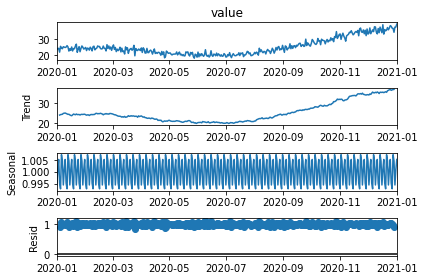

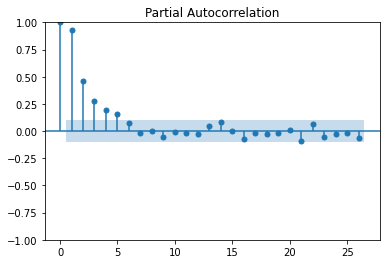

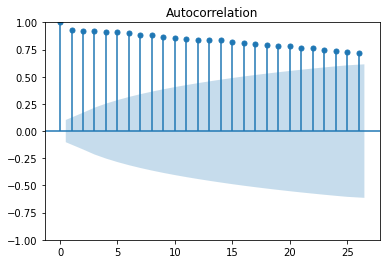

In [7]:
series = df.copy()
# filtering out the other stations. 
series = series[series["station"] == "station_1"]

# make first column a datetime format
series.index = pd.to_datetime(series.date)
# filter out factors "collapses the columns" into a value
series = series['value']

series.head()

decomp = seasonal_decompose(series, model='multiplicative')

# assign each plot it to a variable so the plot doesn't display twice
decomp_plot = decomp.plot()
pacf = plot_pacf(series)
acf  = plot_acf(series)

## Attempt to fit the data

In [8]:
train = series.iloc[:math.floor(series.shape[0] * 0.8)]
test  = series.iloc[math.ceil(series.shape[0] * 0.8):]

print("Shape of train is: ", train.shape)
print("Shape of test is: ", test.shape)

Shape of train is:  (293,)
Shape of test is:  (73,)


In [9]:
stepwise_model = auto_arima(series, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1250.022, Time=1.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1682.718, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1465.156, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1252.361, Time=0.98 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1427.963, Time=0.18 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1251.318, Time=2.03 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1251.360, Time=4.13 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1325.945, Time=0.70 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1252.848, Time=6.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1249.248, Time=1.80 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1427.136, Time=0.21 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1250.725, Time=2.18 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=1250.761, Time=3.95 sec
 ARIMA(2,1,1)(1,1,0)[12]

# Using ARMA-simulator to create regressive time series.

## First define the class generator

In [3]:
# Source: https://github.com/igarizio/ARMA-simulator
import numpy as np


class ARMA:
    """Class that generates WN, AR, MA and ARMA processes."""

    @staticmethod
    def generate_wn(n, sigma=1):
        """Generates a white noise series.

        The code follows:
        y_{t} = \epsilon_{t}

        Args:
            n: length of the series.
            sigma: standard deviation of the innovations.

        Returns:
            np.Array with the series.

        """
        return np.random.normal(0, sigma, size=n)

    @staticmethod
    def generate_ma(n, thetas, mu, sigma=1):
        """Generates a moving average series.

        The code follows:
        y_{t} = \mu + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + ... + \theta_{q}\epsilon_{t-q}

        Args:
            n: length of the series.
            thetas: list of thetas, in the order \theta_{1}, \theta_{2}, ..., \theta_{q}.
            mu: base constant.
            sigma: standard deviation of the innovations (optional).

        Returns:
            np.Array with the series.

        """
        q = len(thetas)
        adj_n = n + q  # We add q values because at the beginning we have no thetas available.
        e_series = ARMA.generate_wn(adj_n, sigma)  # Generating a white noise.

        ma = []
        for i in range(1, adj_n):
            visible_thetas = thetas[0:min(q, i)]  # At first, we only "see" some of the thetas.
            visible_e_series = e_series[i - min(q, i):i]  # The same happens to the white noise.

            reversed_thetas = visible_thetas[::-1]

            try:  # Getting e_t if we can.
                e_t = visible_e_series[-1]
            except IndexError:
                e_t = 0

            # Main equation.
            ma_t = mu + e_t + np.dot(reversed_thetas, visible_e_series)

            ma.append(ma_t)

        ma = ma[max(q-1, 0):]  # Dropping the first values that did not use all the thetas.

        return ma

    @staticmethod
    def generate_ar(n, phis, sigma=1):
        """Generates an autoregressive series.

        The code follows:
        y_{t} = \phi_{1} y_{t-1} + \phi_{2} y_{t-2} + ... + \phi_{p} y_{t-p} + \epsilon_{t}

        Args:
            n: length of the series.
            phis: list of thetas, in the order \phi_{1}, \phi_{2}, ..., \phi_{p}.
            sigma: standard deviation of the innovations (optional).

        Returns:
            np.Array with the series.

        """
        p = len(phis)
        adj_n = n + p  # We add q values because at the beginning we have no phis available.
        e_series = ARMA.generate_wn(adj_n, sigma)  # Generating a white noise.

        ar = [e_series[0]]  # We start the series with a random value
        for i in range(1, adj_n):
            visible_phis = phis[0:min(p, i)]  # At first, we only "see" some of the phis.
            visible_series = ar[i - min(p, i):i]  # The same happens to the white noise.

            reversed_phis = visible_phis[::-1]

            # Main equation.
            ar_t = max(0, e_series[i] + np.dot(reversed_phis, visible_series))

            ar.append(ar_t)

        ar = ar[p:]  # Dropping the first values that did not use all the phis.

        return ar
    
    @staticmethod
    def generate_sar_phis(ar_phis, sar_phis, P, period):
        phis = np.zeros(P * period)
        phis[0:len(ar_phis)] = ar_phis
        for x in range(P):
            phis[((x+1) * period)-1] = sar_phis[x]
            
        return phis
    
    @staticmethod
    def generate_arma(n, phis, thetas, mu, sigma=1):
        """Generates an autoregressive moving average series.

        The code follows:
        y_{t} = \mu + \phi_{1} y_{t-1} + \phi_{2} y_{t-2} + ... + \phi_{p} y_{t-p} + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + ... + \theta_{q}\epsilon_{t-q}

        Args:
            n: length of the series.
            phis: list of thetas, in the order \phi_{1}, \phi_{2}, ..., \phi_{p}.
            thetas: list of thetas, in the order \theta_{1}, \theta_{2}, ..., \theta_{q}.
            mu: base constant.
            sigma: standard deviation of the innovations (optional).

        Returns:
            np.Array with the series.

        """
        p = len(phis)
        q = len(thetas)

        adj_n = n + max(p, q)  # We use max to make sure we cover the lack of coefficients.
        e_series = ARMA.generate_wn(adj_n)  # Base white noise.

        arma = [e_series[0]]  # We start the series with a random value (same as AR).
        for i in range(1, adj_n):
            visible_phis = phis[0:min(p, i)]
            visible_thetas = thetas[0:min(q, i)]

            reversed_phis = visible_phis[::-1]
            reversed_thetas = visible_thetas[::-1]

            visible_series = arma[i - min(p, i):i]
            visible_e_series = e_series[i - min(q, i):i]
            
            try:  # Getting e_t if we can.
                e_t = visible_e_series[-1]
            except IndexError:
                e_t = 0

            # Main equation.
            ar_t = + np.dot(reversed_phis, visible_series)
            ma_t = mu + e_t + np.dot(reversed_thetas, visible_e_series)
            arma_t = ar_t + ma_t

            arma.append(arma_t)

        arma = arma[max(p, q):]  # Dropping the first values that did not use all the phis or thetas.

        return arma


In [4]:
ar_phis = ARMA.generate_sar_phis([0.1, 0.2, 0.3], [0.5, 0.8, 0.6], 3, 12)

In [5]:
len(ar_phis)

36

## Next, set up the parameters.  

In [7]:
phis = ARMA.generate_sar_phis([0.2, -0.1, 0.1], [0.1, 0.2, 0.1], 3, 12)
thetas = [0.1, 0.2, 0.5, 0.05]
n = 300

In [51]:
np.random.rand(2)

array([0.94002406, 0.10849518])

## Plot them

[-0.6458295577229012, 0.010788991734468789]
[0.6662429911437213, 0.0075805784011842015]


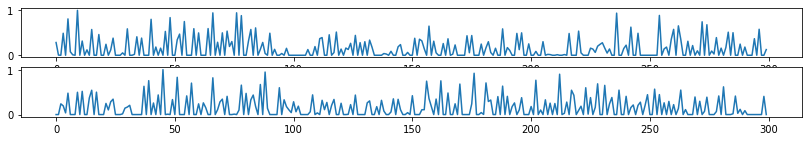

In [8]:
variance = 0

while variance < 0.05:
    ar_coefs = [(x - 0.5) * 2 for x in np.random.rand(2)]
    sar_coefs = [(x - 0.5) * 2 for x in np.random.rand(2)]

    ar_data_1 = ARMA.generate_ar(n, ARMA.generate_sar_phis(ar_coefs, sar_coefs, 2, 6))
    ar_data_2 = ARMA.generate_ar(n, ARMA.generate_sar_phis(ar_coefs, sar_coefs, 2, 6))
    variance = min(np.var(ar_data_1 / max(ar_data_1)), np.var(ar_data_2 / max(ar_data_2)))

print(ar_coefs)
print(sar_coefs)

fig, (ax1, ax2) = plt.subplots(2, figsize=(14,2))
ax1.plot(ar_data_1 / max(ar_data_1))
ax2.plot(ar_data_2 / max(ar_data_2))
plt.show()

In [195]:
print(np.var(ar_data / max(ar_data)))

0.0557573991256078


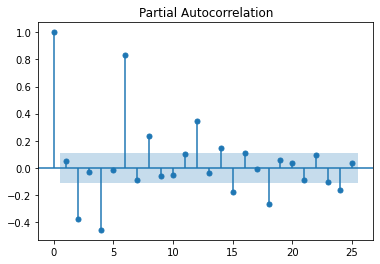

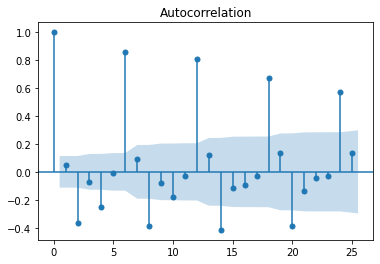

In [196]:
pacf = plot_pacf(np.array(ar_data))
acf  = plot_acf(np.array(ar_data))